In [ ]:
import jax
import jax.numpy as jnp
from jax import vmap, jit
import time
import itertools
import math
from functools import partial
from jax import random
import cirq
import pennylane as qml
from functools import reduce
import numpy as np
from jax.experimental.sparse import BCOO
from scipy.sparse import csr_matrix, lil_matrix, save_npz, load_npz, coo_matrix
from scipy.linalg import expm
import pickle
from joblib import Parallel, delayed, parallel_backend
from jax.scipy.linalg import eigh
import basefunction
from concurrent.futures import ThreadPoolExecutor
from scipy.sparse import kron, eye
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
from tqdm import tqdm



Pauli_list = {
    6: jnp.array([[1, 0], [0, 1]]),
    7: jnp.array([[0, 1], [1, 0]]),
    8: jnp.array([[0, -1j], [1j, 0]]),
    9: jnp.array([[1, 0], [0, -1]])
}

stab1 = {
    0: jnp.array([[1, 0], [0, 0]]),
    1: jnp.array([[0, 0], [0, 1]]),
    2: 0.5 * jnp.array([[1, 1], [1, 1]]),
    3: 0.5 * jnp.array([[1, -1], [-1, 1]]),
    4: 0.5 * jnp.array([[1, -1j], [1j, 1]]),
    5: 0.5 * jnp.array([[1, 1j], [-1j, 1]]),
}

stab2 = {
    0: jnp.array([[2, 0], [0, -1]]),
    1: jnp.array([[-1, 0], [0, 2]]),
    2: 0.5 * jnp.array([[1, 3], [3, 1]]),
    3: 0.5 * jnp.array([[1, -3], [-3, 1]]),
    4: 0.5 * jnp.array([[1, -3j], [3j, 1]]),
    5: 0.5 * jnp.array([[1, 3j], [-3j, 1]]),
}

state_vectors = {
    0: np.array([1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 1]) / np.sqrt(2),
    3: np.array([1, -1]) / np.sqrt(2),
    4: np.array([1, 1j]) / np.sqrt(2),
    5: np.array([1, -1j]) / np.sqrt(2),
}

def generate_haar_random_state(n_qubits):
    dim = 2 ** n_qubits
    key = jax.random.PRNGKey(0)
    real_part = jax.random.normal(key, (dim, dim))
    key, subkey = jax.random.split(key)
    imag_part = jax.random.normal(subkey, (dim, dim))
    X = real_part + 1j * imag_part
    Q, R = jnp.linalg.qr(X)
    D = jnp.diag(R)
    phases = D / jnp.abs(D)
    Q = Q * jnp.conj(phases)[:, jnp.newaxis]
    state = Q[:, 0]
    return state / jnp.linalg.norm(state)

def haardensitymatrix(n_qubits):
    state = generate_haar_random_state(n_qubits)
    return jnp.outer(state, state.conj())

def sanitize_transition_matrix(T):
    T_clipped = jnp.clip(T, 0.0, 1.0)
    T_clipped = jnp.where(T_clipped < 1e-5, 0.0, T_clipped)
    row_sums = jnp.sum(T_clipped, axis=1, keepdims=True)
    row_sums = jnp.where(row_sums == 0, 1.0, row_sums)
    T_normalized = T_clipped / row_sums
    r = T.shape[0]
    uniform_row = jnp.ones((1, r)) / r
    is_zero_row = (row_sums.squeeze() == 0)
    T_normalized = jnp.where(is_zero_row[:, None], uniform_row, T_normalized)
    return T_normalized



def make_valid_density_matrix(matrix):
    matrix = (matrix + matrix.conj().T) / 2
    eigenvalues, eigenvectors = eigh(matrix)
    eigenvalues = jnp.maximum(eigenvalues, 0)
    matrix = eigenvectors @ jnp.diag(eigenvalues) @ eigenvectors.conj().T
    matrix = matrix / jnp.trace(matrix)
    return matrix

def timeevo_process(resultin, resultout):
    transition_matrix1 = basefunction.build_coo_matrix(np.array(resultin), np.array(resultout))
    transition_matrix1 = basefunction.normalize_coo_matrix(transition_matrix1)
    sigma_a_sub = basefunction.construct_sparse_matrix(resultout, resultin, num_qubits)
    rhoin_c = jnp.array(sorted({tuple(s) for s in np.array(resultin)}))
    rhoin_c0 = jnp.array(sorted({tuple(s) for s in np.array(resultout)}))
    expvals_c1 = jax.vmap(basefunction.optimized_compute_multi_trace_stab2, in_axes=(0, None))(O_terms, rhoin_c0)
    expvals_c2 = jax.vmap(lambda x, c: x * c)(expvals_c1, jnp.array(coeffs))
    expvals_c = jnp.sum(expvals_c2, axis=0)

    def calculate_result(rho_true, transition_matrix):
        rhoout_c = transition_matrix @ expvals_c
        def compute_xp_betap_alphap_c(P):
            prhoin_c = basefunction.optimized_compute_multi_trace(P, rhoin_c)
            results = prhoin_c * rhoout_c
            xp = jnp.mean(jnp.array(results))
            betap = (1/3) ** basefunction.count_non_I(P)
            alphap = basefunction.calculate_alpha_p(xp, betap, tilde_epsilon, eta).astype(jnp.float32)
            return alphap
        
        alphap_list = jax.vmap(compute_xp_betap_alphap_c)(all_pauli).astype(jnp.float32)
        results = prho_c * jnp.array(alphap_list)
        composition_result = jnp.sum(results).item()
        ideal_tr = jnp.trace(observation @ rho_true)
        return [ideal_tr, composition_result]
    
    rho_true = basefunction.calrho3(Umatrix, rhoinput)
    composition_result1 = calculate_result(rho_true, transition_matrix1)

    transition_matrix2 = transition_matrix1 @ sigma_a_sub @ transition_matrix1
    rho_true2 = basefunction.calrho3(Umatrix @ Umatrix, rhoinput)
    composition_result2 = calculate_result(rho_true2, transition_matrix2)
    
    rho_true3 = basefunction.calrho3(Umatrix @ Umatrix @ Umatrix, rhoinput)
    transition_matrix3 = transition_matrix2 @ sigma_a_sub @ transition_matrix1
    composition_result3 = calculate_result(rho_true3, transition_matrix3)
    
    rho_true4 = basefunction.calrho3(Umatrix @ Umatrix @ Umatrix @ Umatrix, rhoinput)
    transition_matrix4 = transition_matrix2 @ sigma_a_sub @ transition_matrix2
    composition_result4 = calculate_result(rho_true4, transition_matrix4)
    
    rho_true5 = basefunction.calrho3(Umatrix @ Umatrix @ Umatrix @ Umatrix @ Umatrix, rhoinput)
    transition_matrix5 = transition_matrix3 @ sigma_a_sub @ transition_matrix2
    composition_result5 = calculate_result(rho_true5, transition_matrix5)
    
    rho_true6 = basefunction.calrho3(Umatrix @ Umatrix @ Umatrix @ Umatrix @ Umatrix @ Umatrix, rhoinput)
    transition_matrix6 = transition_matrix3 @ sigma_a_sub @ transition_matrix3
    composition_result6 = calculate_result(rho_true6, transition_matrix6)
    
    return composition_result1, composition_result2, composition_result3, composition_result4, composition_result5, composition_result6

if __name__ == "__main__":
    num_qubits = 2
    tim1 = time.time()
    rhoinput = haardensitymatrix(num_qubits)
    Homoh = [0.5 for i in range(num_qubits)]
    params = (basefunction.Hamiltonian(Homoh, "XY", num_qubits), 10**3)
    H, t = params
    H_np = np.array(H)
    Umatrix_np = expm(-1j * H_np * t)
    Umatrix = jnp.array(Umatrix_np)
    keys_list = basefunction.vakey(num_qubits)
    kappa = 2
    d = 7
    epsilon = 0.4
    delta = 0.01
    k = math.ceil(math.log(2/epsilon, 1.5))
    coeffs, terms = basefunction.calculate_observable_zglobal(num_qubits)
    O_terms = jnp.array(basefunction.convert_terms(terms, num_qubits))
    observation = qml.matrix(qml.Hamiltonian(coeffs, terms))
    all_pauli = jnp.array([list(item) for item in itertools.product([6, 7, 8, 9], repeat=num_qubits) if item.count(7) + item.count(8) + item.count(9) <= k])
    eta = sum(map(abs, coeffs))
    tilde_epsilon = epsilon / (9 * 2**(k+1) * num_qubits**k) * ((basefunction.cal_C_k_d(kappa, d) / 3)**2)

    def custom_function(all_pauli, rhoinput):
        def single_operation(pauli):
            transformed_pauli = basefunction.str2rho(pauli)
            result = jnp.dot(rhoinput, transformed_pauli)
            return jnp.trace(result)
        return vmap(single_operation)(all_pauli)
    prho_c = custom_function(all_pauli, rhoinput)

    Norigin = [2, 6, 8]
    sample_sizes = [int(Norigin[i] * 10000) for i in range(len(Norigin))]
    resultin_list, resultout_list = basefunction.load_results(num_qubits, f'./shadows/{num_qubits}qubits_time_evolution_shadows.csv')
    jax.config.update("jax_enable_x64", True)

    num_runs = 50

    csv_file = './data/time_evolution_results.csv'
    headers = ['t0_mean','t0_std', 't1_mean', 't1_std', 't2_mean', 't2_std', 't3_mean', 't3_std', 't4_mean', 't4_std', 't5_mean', 't5_std']

    # Initialize CSV file with headers
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
    ideal_tr_list = ["ideal"]
    # Iterate over each sample size N
    for i, N in tqdm(enumerate(sample_sizes), total=len(sample_sizes), desc="Processing sample sizes"):
        # Store RMSE results for each t (t0-t5) across num_runs
        run_result_list = {
            't0': [], 't1': [], 't2': [],
            't3': [], 't4': [], 't5': []
        }
        
        # Repeat for num_runs times
        for times in range(num_runs):
            resultin = resultin_list[times][:N]
            resultout = resultout_list[times][:N]
            
            # Get t0-t5, each t is (ideal_tr, composition_result)
            t0, t1, t2, t3, t4, t5 = timeevo_process(resultin, resultout)
            t_list = [t0, t1, t2, t3, t4, t5]
            t_names = ["t0", "t1", "t2", "t3", "t4", "t5"]
        
            
            # Calculate RMSE for each t and store
            for t_name, t_val in zip(t_names, t_list):
                ideal_tr, composition_result = t_val
                if i==0 and times==0:
                    ideal_tr_list.append(ideal_tr)
                    ideal_tr_list.append(0)
                run_result_list[t_name].append(composition_result)
        
    
        avg_rmse = [
            N,  # First column is N
            np.mean(run_result_list['t0']), np.std(run_result_list['t0']),
            np.mean(run_result_list['t1']), np.std(run_result_list['t1']),
            np.mean(run_result_list['t2']), np.std(run_result_list['t2']),
            np.mean(run_result_list['t3']), np.std(run_result_list['t3']),
            np.mean(run_result_list['t4']), np.std(run_result_list['t4']),
            np.mean(run_result_list['t5']), np.std(run_result_list['t5']),
        ]
        
        # Append average RMSE to CSV
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(avg_rmse)
    if ideal_tr_list is not None: 
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(ideal_tr_list)

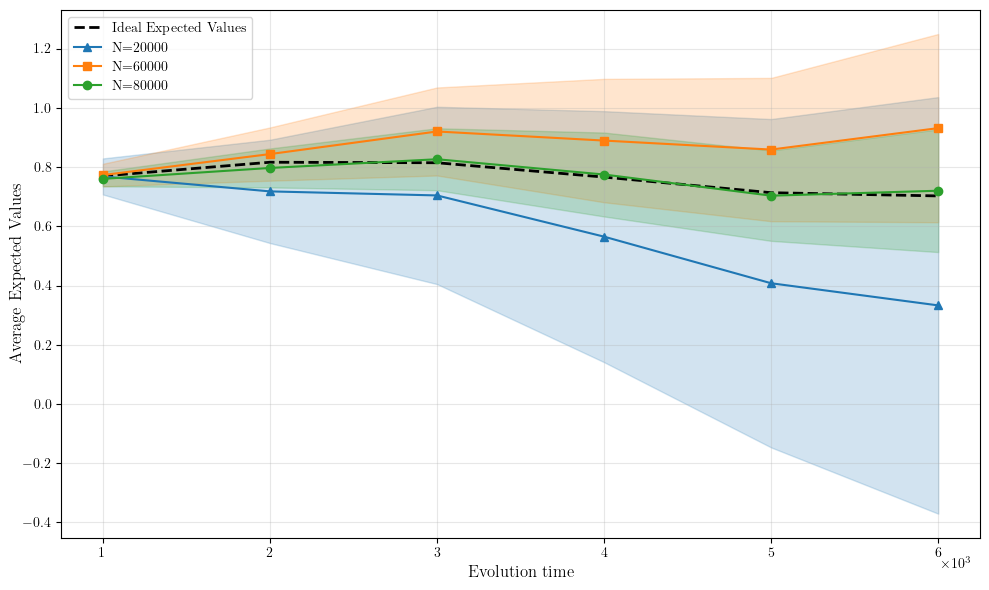

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

df = pd.read_csv('./data/time_evolution_results.csv')

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'
plt.rcParams['mathtext.bf'] = 'Arial:bold'

selected_N = ["20000", "60000", "80000"]
grouped_mean = df[df['N'].isin(selected_N)][[f't{i}_mean' for i in range(6)]]
grouped_std = df[df['N'].isin(selected_N)][[f't{i}_std' for i in range(6)]]

baseline_values = df[df['N'] == 'ideal'][[f't{i}_mean' for i in range(6)]].values.flatten().tolist()

plt.figure(figsize=(10, 6))
x_positions = np.arange(1,7)

plt.plot(x_positions, baseline_values, 'k--', label='Ideal Expected Values', linewidth=2)

# Define markers and corresponding N values
markers = ['^', 's', 'o']  # Triangle, Square, Circle
n_labels = ["20000", "60000", "80000"]

for i, n in enumerate(grouped_mean.index):
    y_values = grouped_mean.loc[n].values
    std_values = grouped_std.loc[n].values

    # Use specific marker for each line
    line, = plt.plot(x_positions, y_values, marker=markers[i], label=f'N={n_labels[i]}')
    plt.fill_between(x_positions,
                     y_values - std_values / 2,
                     y_values + std_values / 2,
                     color=line.get_color(),
                     alpha=0.2)

plt.xlabel('Evolution time', fontsize=12)
plt.ylabel('Average Expected Values', fontsize=12, rotation=90, va='center')

plt.text(6.2, plt.ylim()[0] - 0.06*(plt.ylim()[1]-plt.ylim()[0]), 
         r'$\times 10^3$', 
         fontsize=10, 
         ha='right', 
         va='bottom')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plt.savefig('fig4.svg', format='svg')
plt.show()
